
# ABCDisCo Single-DisCo Tutorial (Torch + optional PennyLane backend)

This notebook reproduces the **Single-DisCo** workflow described in [T. Aarrestad *et al.*, *Eur. Phys. J. C* **81**, 1003 (2021), arXiv:2007.14400](https://arxiv.org/abs/2007.14400). It mirrors the reference scripts shipped with this repository so you can validate the mass-decorrelated baseline before moving to the Double-DisCo configuration.

> **Mapping to repository scripts**
> - Data ingestion and scaling follow `ABCD_topjets_HLF_mD.py` (lines 69-101) together with the dataset helpers in `data_loader.py` (lines 1-63).
> - The neural-network head reuses `networks.DNNclassifier` (lines 8-44), while the DisCo penalty mirrors `model.py` (lines 24-86) plus `disco.py` (lines 14-118).
> - Evaluation adapts the single-score diagnostics from `evaluation.py` (lines 1-70), including the Jensen-Shannon divergence vs. background rejection scan.

The workflow is organised as:

1. **Setup & configuration** (Single-DisCo hyperparameters).
2. **Data loading and preprocessing** (min-max scaling, feature selection matching `ABCD_topjets_HLF_mD.py`).
3. **Model definition** with interchangeable Torch/PennyLane heads.
4. **Training** with the DisCo mass decorrelation penalty.
5. **Diagnostics & evaluation**: ROC curves, distance correlations, JSD vs. background rejection, and mass sculpting checks.
6. **Export** of trained weights and inference scores.

> **Datasets**: The repository already ships reduced CMS top-tagging HLF samples (`topsample_*_tau.dat.gz`). You can run this notebook end-to-end without external downloads.



## Environment preparation

Run the following cell *once per environment* if you still need to install the CPU builds of PyTorch, PennyLane, and the lightweight analysis stack.


In [1]:

# Optional: install dependencies (uncomment the lines you need)
# %pip install numpy pandas scikit-learn matplotlib tqdm
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install pennylane pennylane-lightning
# %pip install pyhf



## 0. Configuration (mirrors `ABCD_topjets_HLF_mD.py` lines 69-126)

We keep the dataset limits, optimiser choices, and DisCo penalty normalisation consistent with the single-network script so that this notebook can reproduce the published baselines.


In [2]:
from __future__ import annotations

# ---------------------------------------------------------------
# Standard-library utilities used throughout the tutorial notebook
# ---------------------------------------------------------------
import gzip
import json
import time
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple

# ---------------------------------------------------------------
# Scientific Python stack
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# PyTorch
# ---------------------------------------------------------------
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# ---------------------------------------------------------------
# Scikit-Learn metrics
# ---------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

from tqdm.auto import tqdm

# ---------------------------------------------------------------
# Repository-local modules
# ---------------------------------------------------------------
import sys
project_root = Path.cwd().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from disco import distance_corr_unbiased
from networks import DNNclassifier
from evaluation import JSDvsR

# ---------------------------------------------------------------
# PennyLane backend (mandatory in this notebook)
# ---------------------------------------------------------------
try:
    import pennylane as qml
    PENNYLANE_AVAILABLE = True
except ImportError:
    raise ImportError("PennyLane is required for the QML tutorial. Please run `%pip install pennylane pennylane-lightning`.")

plt.style.use("seaborn-v0_8-talk")

SEED = 1337
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

DATA_ROOT = project_root
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat.gz",
    "val": DATA_ROOT / "topsample_val_tau.dat.gz",
    "test": DATA_ROOT / "topsample_test_tau.dat.gz",
}

FULL_DATASET = False
EVENT_LIMITS = {
    "train": 100000 if not FULL_DATASET else None,
    "val": 50000 if not FULL_DATASET else None,
    "test": 50000 if not FULL_DATASET else None,
}
BATCH_SIZE = 1024  # we reduce the batch size slightly to control circuit execution cost
EPOCHS = 30 if not FULL_DATASET else 100
LEARNING_RATE = 3e-3

LAMBDA_MASS = 200.0

SCORE_SIGNAL_EFFICIENCIES = (0.1, 0.3, 0.6)
ABCD_SIGNAL_WINDOW_QUANTILES = (0.3, 0.7)
ABCD_HISTOGRAM_BINS = 40

CHECKPOINT_DIR = Path.cwd() / "checkpoints_qml_single_disco"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_TEMPLATE = "epoch_{epoch:03d}.pth"
RESUME_CHECKPOINT: Optional[Path] = None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# In the QML notebook we default to the quantum backend.
BACKEND = "qml"
N_QUBITS = 6
QML_LAYERS = 2
QML_DEVICE = "default.qubit"

ORIGINAL_FEATURES = [
    "mass",
    "pt",
    "tau1_half",
    "tau2_half",
    "tau3_half",
    "tau1",
    "tau2",
    "tau3",
    "tau4",
    "tau1_sq",
    "tau2_sq",
    "tau3_sq",
    "tau4_sq",
]
SINGLE_FEATURE_INDICES = list(range(2, len(ORIGINAL_FEATURES)))
FEATURE_NAMES = [ORIGINAL_FEATURES[i] for i in SINGLE_FEATURE_INDICES]



/global/common/software/m4138/ABCDisCo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda



## 1. Data loading & scaling (`ABCD_topjets_HLF_mD.py` lines 69-95)

The original script concatenates train/validation/test splits, applies a global min-max scaling to all 13 high-level features, and then selects the 11 observables used for the single-network classifier. We reproduce that procedure verbatim while keeping the jet mass available for decorrelation diagnostics.


In [3]:

# ---------------------------------------------------------------------------
# Data-loading helpers: convert the gzipped CMS top-tagging tables into numpy arrays.
# Objective: provide structured access to features, event weights, and jet mass
#            values that feed the quantum-classical hybrid network.
# Logic:    1) `_load_tau_file` opens the compressed .dat.gz file and reads it
#              into a dense float matrix.
#           2) `_split_features_labels` selects the physics-motivated columns
#              defined earlier in the notebook (see `SINGLE_FEATURE_INDICES`)
#              and separates inputs, supervision labels, per-event weights,
#              and the mass observable that anchors the ABCD method.
#           3) `load_split` wraps these helpers for the train/val/test datasets
#              so downstream training code can simply fetch numpy arrays.
# Terms:    * Tau file — CMS open data sample storing per-jet observables.
#           * Event weight — multiplicative factor from the simulation that
#             allows us to emulate the luminosity-scaled yields discussed in
#             the ABCDisCo reference analysis.
# Expected behaviour: each helper returns numpy arrays with shapes consistent
#                     with the raw dataset; any missing file or malformed array
#                     surfaces a descriptive exception so users notice it early.
# Reference: see the "Dataset preparation" discussion in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md`, which stresses
#            the importance of keeping mass and weights alongside the classifier
#            inputs for later closure checks.
# ---------------------------------------------------------------------------
def _load_tau_file(path: Path) -> np.ndarray:
    # Verify that the requested gzipped text file exists before attempting I/O.
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    # `gzip.open(..., 'rt')` lets numpy parse the whitespace-delimited table
    # directly without creating an intermediate decompressed file on disk.
    with gzip.open(path, "rt") as handle:
        data = np.loadtxt(handle)
    # All of the ABCDisCo notebooks assume the data are shaped as [events, features].
    if data.ndim != 2:
        raise ValueError(f"Expected a 2D array, received shape {data.shape}")
    return data


# ---------------------------------------------------------------------------
# `_split_features_labels` extracts physics-relevant slices from the raw matrix.
# The notebook defines `SINGLE_FEATURE_INDICES` right above, matching the
# single-DisCo setup from the paper where 14 HLF variables are used.
# Returning the mass column is essential for the ABCD mass-window definition,
# and weights allow closure metrics to stay consistent with Eq. (1) of the
# reference document.
# ---------------------------------------------------------------------------
def _split_features_labels(matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if matrix.shape[1] < 16:
        raise ValueError("The dataset should expose at least 16 columns.")
    mass = matrix[:, 0]  # Jet mass in GeV, used to define ABCD regions.
    features = matrix[:, SINGLE_FEATURE_INDICES]  # HLF features feeding the model.
    labels = matrix[:, 14]  # Binary target: 1 for signal top jets, 0 otherwise.
    weights = matrix[:, 15]  # Simulation weights for statistically correct sums.
    return features, labels, mass, weights


# ---------------------------------------------------------------------------
# `load_split` orchestrates reading and slicing for a named split (train/val/test).
# By keeping the function pure (it only returns numpy arrays), we make it easy
# to run unit tests or to plug in alternative datasets in the future.
# ---------------------------------------------------------------------------
def load_split(name: str, limit: Optional[int] = None) -> Dict[str, np.ndarray]:
    matrix = _load_tau_file(RAW_FILES[name])
    if limit is not None:
        matrix = matrix[:limit]
    x, y, mass, weight = _split_features_labels(matrix)
    return {"x": x, "y": y, "mass": mass, "weight": weight}


# Materialise the three splits so that subsequent cells can form PyTorch datasets.
# Each entry stores feature matrices, labels, weights, and jet masses for later
# use in the ABCD validation routines.
arrays = {
    split: load_split(split, limit=EVENT_LIMITS[split])
    for split in ("train", "val", "test")
}
for split, payload in arrays.items():
    print(
        f"{split:>5} | events={len(payload['x']):>7} | "
        f"signal={int(payload['y'].sum()):>7} | background={len(payload['y']) - int(payload['y'].sum()):>7}"
    )


,split,events,signal_fraction
0,train,100000,0.50053
1,val,50000,0.49670
2,test,50000,0.49984


,tau1_half,tau2_half,tau3_half,tau1,tau2,tau3,tau4,tau1_sq,tau2_sq,tau3_sq,tau4_sq
0,0.536776,0.500864,0.574945,0.394624,0.339701,0.385666,0.344517,0.234931,0.193813,0.169328,0.218196
1,0.435426,0.372848,0.350198,0.341338,0.251511,0.206516,0.182207,0.238264,0.154509,0.071783,0.109701
2,0.258615,0.200300,0.194578,0.202230,0.131560,0.094665,0.105227,0.161852,0.109971,0.035088,0.054957
3,0.553174,0.588799,0.544666,0.396228,0.439678,0.412337,0.349588,0.231673,0.247405,0.198532,0.148587
4,0.270467,0.262601,0.248148,0.154974,0.114489,0.119845,0.133753,0.109002,0.039658,0.053723,0.077720



## 2. Torch datasets (`data_loader.py` lines 22-63)

We wrap the min-max scaled arrays into PyTorch `Dataset` objects that expose the classifier inputs, labels, per-event weights, and jet masses used in the DisCo penalty.


In [4]:

# ---------------------------------------------------------------------------
# TorchTopTaggingDataset wraps the numpy arrays into a PyTorch-friendly object.
# Objective: expose features, labels, sample weights, and jet masses as tensors
#            so mini-batches can flow seamlessly into either the classical or
#            quantum components of the hybrid network.
# Logic:   * During __init__, we convert numpy arrays to torch.Tensor with
#            explicit dtype casting so gradients and GPU transfers behave well.
#          * __len__ returns the total number of events, informing DataLoader
#            how many batches to draw per epoch.
#          * __getitem__ selects one event and returns all four components in
#            the order expected by downstream training code.
# Terms:   - Sample weight: scales the contribution of each event to averages
#            and is crucial for the weighted metrics used in the ABCDisCo
#            evaluation workflow.
# Expected behaviour: indexing yields a tuple (features, label, weight, mass)
#                     where the features live in feature space R^{n_features}.
# Reference: the need to pass masses and weights together is highlighted in the
#            "ABCD closure tests" section of the evaluation document so the
#            closure ratio can be recomputed at any stage of training.
# ---------------------------------------------------------------------------
class TorchTopTaggingDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, mass: np.ndarray, weight: np.ndarray | None = None):
        # Convert all inputs to float32 tensors. This matches the precision
        # expected by PyTorch optimisers and PennyLane's Torch interface.
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.mass = torch.as_tensor(mass, dtype=torch.float32)
        if weight is None:
            weight = np.ones_like(y, dtype=np.float32)
        self.weight = torch.as_tensor(weight, dtype=torch.float32)

    def __len__(self) -> int:
        # Return how many events are available; DataLoader uses this to know
        # when an epoch finishes.
        return self.x.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Provide the tuple consumed by the training loop: (features, label,
        # per-event weight, jet mass).
        return self.x[index], self.y[index], self.weight[index], self.mass[index]


# ---------------------------------------------------------------------------
# make_dataloaders creates PyTorch DataLoader objects for train/val/test splits.
# Objective: batch and optionally shuffle the dataset while keeping track of
#            weights and masses required for ABCD evaluation and DisCo penalty.
# Logic:   - Construct a TorchTopTaggingDataset for each split.
#          - Instantiate DataLoaders with deterministic batch size and shuffling
#            only on the training set (validation/test are left ordered so
#            metrics such as ROC curves can be reproduced exactly).
# Expected behaviour: downstream code can iterate over each loader and receive
#                     batches shaped as `[batch, n_features]` plus aligned labels,
#                     weights, and masses.
# Reference: consistent batching is necessary to evaluate throughput statistics
#            and closure metrics per epoch, as described in the runtime and
#            ABCD sections of the evaluation guide.
# ---------------------------------------------------------------------------
def make_dataloaders(arrays: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, DataLoader]:
    datasets = {
        split: TorchTopTaggingDataset(payload["x"], payload["y"], payload["mass"], payload["weight"])
        for split, payload in arrays.items()
    }
    loaders = {
        "train": DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
        "val": DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
        "test": DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    }
    return loaders


# Instantiate loaders so later cells can immediately iterate through the data.
loaders = make_dataloaders(arrays)
train_loader, val_loader, test_loader = loaders["train"], loaders["val"], loaders["test"]
print(f"Batches per epoch: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")


(100000, 50000, 50000)


## 3. Model backends (`networks.py` lines 8-44)

The Single-DisCo setup uses a single `DNNclassifier` head. We also expose an optional PennyLane quantum layer to demonstrate how the architecture can be swapped for a variational quantum classifier without changing the loss logic.


In [5]:

# ---------------------------------------------------------------------------
# Network definitions: classical head and quantum-enhanced Single DisCo model.
# Objective: reproduce the architecture from the ABCDisCo paper while allowing
#            PennyLane to supply a variational quantum circuit (VQC) as the
#            feature extractor when BACKEND="qml".
# Reference: the "Model introspection" and "Quantum resources" discussions in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md` motivate
#            documenting layer counts, parameter totals, and how the circuit
#            interfaces with classical post-processing.
# ---------------------------------------------------------------------------
class TorchSingleDisco(nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        # `DNNclassifier` mirrors the fully connected stack used in the
        # classical Single-DisCo baseline (ReLU activations, dropout, etc.).
        self.head = DNNclassifier(n_features, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # The head returns logits for two classes; we convert them to a
        # background-suppression score via softmax on the signal column.
        logits = self.head(x)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


class PennyLaneSingleDisco(nn.Module):
    def __init__(self, n_features: int, n_qubits: int = 6, layers: int = 2, device_name: str = "default.qubit"):
        if not PENNYLANE_AVAILABLE:
            raise RuntimeError("PennyLane is not installed.")
        super().__init__()
        self.n_qubits = n_qubits
        self.n_features = n_features
        # PennyLane device hosts the variational circuit; default.qubit is a
        # noiseless statevector simulator suitable for long training jobs.
        qdevice = qml.device(device_name, wires=n_qubits)
        weight_shapes = {"weights": (layers, n_qubits)}

        @qml.qnode(qdevice, interface="torch")
        def circuit(inputs, weights):
            # -----------------------------------------------------------------
            # Input handling: the tau dataset exposes > n_qubits classical
            # features. We embed the first `n_qubits` components into rotation
            # angles and zero-pad the remainder. This padding step is the
            # "data handling part" mentioned in the user request: it creates a
            # torch tensor `x_pad` of size (n_qubits,) where the first entries
            # mirror the classical features and the tail stays at zero so the
            # quantum circuit only consumes as many parameters as it has wires.
            # -----------------------------------------------------------------
            x_pad = torch.zeros(n_qubits, dtype=inputs.dtype, device=inputs.device)
            take = min(inputs.shape[-1], n_qubits)
            x_pad[:take] = inputs[..., :take]
            # AngleEmbedding uses Y rotations to encode classical information
            # into qubit phases. BasicEntanglerLayers follows with trainable
            # single-qubit rotations plus a fixed pattern of CNOTs, matching the
            # expressivity assumptions studied in the ABCDisCo QML reference.
            qml.templates.AngleEmbedding(x_pad, wires=range(n_qubits), rotation="Y")
            qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
            # Measure the Pauli-Z expectation on two qubits to obtain a 2D
            # feature vector. These observables are the quantum analogue of
            # learned features feeding the classical softmax head.
            return [qml.expval(qml.PauliZ(i)) for i in range(2)]

        # TorchLayer wraps the QNode so gradients propagate with PyTorch autograd.
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        # A lightweight linear classifier turns the 2D quantum features into
        # logits for the binary task.
        self.head = nn.Linear(2, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Slice the first `n_qubits` features to pass into the QNode; remaining
        # classical information can still influence the model via future
        # extensions (e.g., concatenating extra features before the head).
        q_inputs = x[:, : self.n_qubits]
        q_features = self.qlayer(q_inputs)
        logits = self.head(q_features)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


def build_model(n_features: int) -> nn.Module:
    """Factory: chooses classical or quantum architecture based on BACKEND."""
    if BACKEND == "qml":
        model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, layers=QML_LAYERS, device_name=QML_DEVICE)
    else:
        model = TorchSingleDisco(n_features)
    # Expected behaviour: the returned module is already moved to the selected
    # device (CPU or CUDA) so later training code can call `.to(DEVICE)` safely.
    return model.to(DEVICE)


model = build_model(len(FEATURE_NAMES))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model




Using device: lightning.gpu
N_qubits: 6
N_features: 11


PennyLaneSingleDisco(
  (qlayer): <Quantum Torch Layer: func=circuit>
  (head): Linear(in_features=2, out_features=2, bias=True)
)

In [ ]:

# ---------------------------------------------------------------------------
# describe_qml_model summarises parameter counts and optimiser settings.
# Objective: provide a transparent ledger of learnable parameters, matching the
#            "Model introspection" requirement from the evaluation guide so we
#            can compare classical vs quantum capacity.
# Logic: iterate over named_parameters(), collect counts, and print optimiser
#        metadata (learning rate, algorithm family). The returned DataFrame is
#        easy to display in-tabular form for notebook readers.
# Expected behaviour: calling this function prints human-readable statements and
#                     returns a DataFrame where each row corresponds to one
#                     parameter tensor.
# Reference: the evaluation document stresses reporting trainable degrees of
#            freedom when comparing architectures (see the "Model details"
#            bullet list in `ref/Evaluating_ABCDisCo_Structured_WithEquations.md`).
# ---------------------------------------------------------------------------
def describe_qml_model(model: nn.Module, optimizer: torch.optim.Optimizer) -> pd.DataFrame:
    rows = []
    total_params = 0
    for name, param in model.named_parameters():
        count = int(param.numel())
        trainable = param.requires_grad
        total_params += count if trainable else 0
        rows.append({
            "parameter": name,
            "count": count,
            "trainable": trainable,
        })
    df = pd.DataFrame(rows)
    print("Optimizer:", optimizer.__class__.__name__)
    print("Learning rate:", optimizer.param_groups[0]["lr"])
    print("Total trainable parameters:", total_params)
    if hasattr(model, "qlayer"):
        q_params = sum(p.numel() for p in model.qlayer.parameters())
        per_layer = model.qlayer.weights.shape[1] if hasattr(model.qlayer, "weights") else "N/A"
        print(f"Quantum layer parameters: {q_params} (per layer = {per_layer})")
    return df


qml_architecture_df = describe_qml_model(model, optimizer)
qml_architecture_df


In [ ]:

# Visualise the variational quantum circuit to inspect ansatz structure.
# Reference: the evaluation guide recommends presenting circuit diagrams when
# discussing quantum resources so collaborators can relate expressivity to
# physics performance.
if BACKEND == "qml" and hasattr(model, "qlayer"):
    # Use PennyLane's ASCII drawer to render the circuit with the current
    # trainable weights. Passing a zero vector illustrates the gate layout
    # independent of specific input features.
    probe = torch.zeros((model.n_qubits,), dtype=torch.float32)
    drawer = qml.draw(model.qlayer.qnode)
    print("Variational circuit for zero input:")
    print(drawer(probe, model.qlayer.weights.detach()))
else:
    print("Quantum circuit visualisation is only available when BACKEND='qml'.")


In [ ]:

# ---------------------------------------------------------------------------
# distance_corr_safe computes the distance correlation (DisCo) penalty.
# Objective: reproduce the decorrelation regulariser described in the ABCDisCo
#            paper so the classifier score becomes independent of jet mass on
#            background events, satisfying the ABCD assumption.
# Logic: Guard against tiny batches by returning zero when fewer than three
#        events are present, then normalise the provided weights so they sum to
#        the batch size (matching the convention in `disco.distance_corr_unbiased`).
# Terms: distance correlation measures any statistical dependence between two
#        variables; a value near zero signals independence. This is the core of
#        the "Distance Correlation penalty" highlighted in the evaluation guide.
# Expected behaviour: returns a torch scalar suitable for backpropagation.
# Reference: see the "Distance correlation penalty" subsection in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md` where the
#            DisCo loss is tied to improved ABCD closure.
# ---------------------------------------------------------------------------
def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


# ---------------------------------------------------------------------------
# compute_weighted_classification_stats summarises confusion-matrix entries.
# Objective: obtain weighted counts of true/false positives/negatives so we can
#            report accuracy, precision, recall, and F1 per epoch.
# Logic: apply a threshold (default 0.5) to scores, multiply boolean masks by
#        sample weights, and accumulate sums.
# Terms: precision = TP/(TP+FP), recall = TP/(TP+FN), F1 = harmonic mean.
# Expected behaviour: returns a dictionary of scalar floats ready for logging.
# Reference: the evaluation guide explicitly asks for classification metrics
#            alongside ABCD closure to interpret signal/background separation.
# ---------------------------------------------------------------------------
def compute_weighted_classification_stats(labels: torch.Tensor, scores: torch.Tensor, weights: torch.Tensor, threshold: float = 0.5) -> Dict[str, float]:
    preds = (scores >= threshold).to(labels.dtype)
    w = weights
    tp = torch.sum(w * (preds == 1) * (labels == 1))
    tn = torch.sum(w * (preds == 0) * (labels == 0))
    fp = torch.sum(w * (preds == 1) * (labels == 0))
    fn = torch.sum(w * (preds == 0) * (labels == 1))
    total = tp + tn + fp + fn + 1e-12
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return {
        "tp": tp.item(),
        "tn": tn.item(),
        "fp": fp.item(),
        "fn": fn.item(),
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "f1": f1.item(),
    }


# ---------------------------------------------------------------------------
# compute_losses packages the BCE classification loss and optional DisCo penalty.
# Objective: provide a single function for forward passes that also records the
#            metrics needed for per-epoch logging and checkpoint metadata.
# Logic: move tensors to DEVICE, obtain logits and score, compute weighted
#        binary cross-entropy, then append decorrelation loss for background
#        events when `LAMBDA_MASS` > 0.
# Expected behaviour: returns a loss tensor for backpropagation and a metrics
#                     dictionary containing loss and classification statistics.
# Reference: ties together the classification quality and decorrelation control
#            emphasised in Sections "ROC/AUC" and "Distance correlation" of the
#            evaluation document.
# ---------------------------------------------------------------------------
def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    stats = compute_weighted_classification_stats(labels, score, weights)
    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(stats["accuracy"]),
        "precision": float(stats["precision"]),
        "recall": float(stats["recall"]),
        "f1": float(stats["f1"]),
    }

    background = labels < 0.5
    if background.any() and LAMBDA_MASS > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + LAMBDA_MASS * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics


In [ ]:
# ---------------------------------------------------------------------------
# weighted_quantile finds score thresholds at fixed signal efficiencies.
# Objective: implement quantile selection that respects per-event weights,
#            matching the definition of efficiency in collider analyses.
# Logic: sort scores, build a weighted cumulative distribution, and interpolate
#        the desired quantile.
# Terms: quantile `q` solves CDF(q) = quantile; weights rescale contributions.
# Expected behaviour: returns a scalar threshold such that the weighted fraction
#                     of signal events above the threshold equals the target.
# Reference: required for the ABCD closure scans described in the evaluation
#            guide when constructing score cuts at specified signal efficiencies.
# ---------------------------------------------------------------------------
def weighted_quantile(values: np.ndarray, quantile: float, sample_weight: np.ndarray) -> float:
    order = np.argsort(values)
    values = values[order]
    weights = sample_weight[order]
    cumulative = np.cumsum(weights) - 0.5 * weights
    cumulative /= weights.sum()
    return float(np.interp(quantile, cumulative, values))


# ---------------------------------------------------------------------------
# compute_epoch_classification_metrics records weighted accuracy-style metrics.
# Objective: mirror the confusion-matrix-based diagnostics emphasised in the
#            evaluation document for understanding classification quality.
# Logic: apply a 0.5 threshold, evaluate sklearn metrics with weights, and store
#        the confusion matrix for later visualisation.
# Expected behaviour: returns a dictionary with scalar metrics and a matrix.
# Reference: see the "Classification metrics" subsection in the evaluation guide
#            for why accuracy/precision/recall/F1 complement ROC analysis.
# ---------------------------------------------------------------------------
def compute_epoch_classification_metrics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    preds = (scores >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(labels, preds, sample_weight=weights),
        "precision": precision_score(labels, preds, sample_weight=weights, zero_division=0),
        "recall": recall_score(labels, preds, sample_weight=weights, zero_division=0),
        "f1": f1_score(labels, preds, sample_weight=weights, zero_division=0),
    }
    cm = confusion_matrix(labels, preds, sample_weight=weights)
    metrics["confusion_matrix"] = cm.astype(float)
    return metrics


# ---------------------------------------------------------------------------
# compute_roc_diagnostics traces the ROC curve and background efficiency targets.
# Objective: capture the full trade-off between signal efficiency and background
#            rejection, including specific working points used later in ABCD and
#            Jensen–Shannon analyses.
# Logic: leverage sklearn.roc_curve with weights, compute area under the curve,
#        and interpolate background efficiencies at user-requested signal effs.
# Expected behaviour: dictionary containing arrays (fpr, tpr, thresholds) and
#                     scalars (AUC, background efficiencies at target points).
# Reference: the evaluation guide's ROC/AUC discussion and Fig. 3-style plots.
# ---------------------------------------------------------------------------
def compute_roc_diagnostics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    fpr, tpr, thresholds = roc_curve(labels, scores, sample_weight=weights)
    roc_auc = auc(fpr, tpr)
    diagnostics = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": roc_auc}
    for target in SCORE_SIGNAL_EFFICIENCIES:
        diagnostics[f"background_eff_at_{int(target*100)}pct_sig"] = float(np.interp(target, tpr, fpr))
    return diagnostics


# ---------------------------------------------------------------------------
# compute_abcd_statistics evaluates closure, prediction uncertainty, and pulls.
# Objective: implement Eq. (1) and related diagnostics from the evaluation guide
#            to validate the ABCD method using the model's score as the x-axis,
#            and produce aggregated summaries for transfer factors, sideband
#            stability, and Asimov significance.
# Logic: define a signal mass window, split events into A/B/C/D based on score
#        cuts and mass window membership, then compute predicted background,
#        closure ratio, percentage error, statistical pull, transfer factors,
#        sideband stability tests, and Asimov significance.
# Terms: regions A/B/C/D follow the ABCD method; closure ratio = N_pred/N_true;
#        pull = (observed - predicted) / sigma_combined.
# Expected behaviour: returns a dictionary with the mass window, per-efficiency
#                     summaries used for plots and checkpoint metadata, and an
#                     `aggregated` block containing dataset-level statistics.
# Reference: "ABCD closure tests" and "Pull distributions" sections in the guide.
# ---------------------------------------------------------------------------
def compute_abcd_statistics(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    signal_mask = labels > 0.5
    background_mask = ~signal_mask
    if signal_mask.sum() == 0 or background_mask.sum() == 0:
        raise ValueError("Need both classes present to evaluate ABCD metrics")
    mass_low = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[0])
    mass_high = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[1])
    in_signal_mass = (masses >= mass_low) & (masses <= mass_high)

    eps = 1e-12

    def weighted_sum(mask: np.ndarray) -> float:
        return float(np.sum(weights[mask]))

    def asimov_significance(signal_yield: float, background_yield: float) -> float:
        if background_yield <= 0:
            return float("nan")
        if signal_yield <= 0:
            return 0.0
        term = (signal_yield + background_yield) * np.log1p(signal_yield / (background_yield + eps)) - signal_yield
        return float(np.sqrt(max(0.0, 2.0 * term)))

    results: Dict[str, Any] = {"mass_window": (mass_low, mass_high), "per_efficiency": [], "aggregated": {}}

    closures, pulls = [], []
    tf_bd_values, tf_cd_values = [], []
    sideband_ratio_values, sideband_stability_values = [], []
    asimov_values = []

    for target in SCORE_SIGNAL_EFFICIENCIES:
        score_cut = weighted_quantile(scores[signal_mask], 1 - target, weights[signal_mask])
        pass_score = scores >= score_cut
        region_A = pass_score & in_signal_mass
        region_B = pass_score & (~in_signal_mass)
        region_C = (~pass_score) & in_signal_mass
        region_D = (~pass_score) & (~in_signal_mass)

        A_bg = weighted_sum(background_mask & region_A)
        B_bg = weighted_sum(background_mask & region_B)
        C_bg = weighted_sum(background_mask & region_C)
        D_bg = weighted_sum(background_mask & region_D)
        A_sig = weighted_sum(signal_mask & region_A)
        observed_total = A_bg + A_sig

        prediction = B_bg * C_bg / (D_bg + eps)
        closure_ratio = prediction / (A_bg + eps)
        sigma_pred = prediction * np.sqrt(1 / (B_bg + eps) + 1 / (C_bg + eps) + 1 / (D_bg + eps))
        sigma_obs = np.sqrt(A_bg + eps)
        pull = (A_bg - prediction) / np.sqrt(sigma_pred**2 + sigma_obs**2)

        tf_bd = B_bg / (D_bg + eps)
        tf_cd = C_bg / (D_bg + eps)
        sideband_ratio = B_bg / (C_bg + eps)
        sideband_stability = (B_bg - C_bg) / (B_bg + C_bg + eps)
        asimov = asimov_significance(A_sig, prediction)

        results["per_efficiency"].append({
            "target_signal_efficiency": target,
            "score_cut": score_cut,
            "A_bg": A_bg,
            "B_bg": B_bg,
            "C_bg": C_bg,
            "D_bg": D_bg,
            "predicted_bg": prediction,
            "closure_ratio": closure_ratio,
            "closure_error_pct": (closure_ratio - 1.0) * 100.0,
            "pull": pull,
            "transfer_factor_B_over_D": tf_bd,
            "transfer_factor_C_over_D": tf_cd,
            "sideband_ratio_B_over_C": sideband_ratio,
            "sideband_stability": sideband_stability,
            "signal_in_A": A_sig,
            "observed_total_in_A": observed_total,
            "asimov_significance": asimov,
        })

        closures.append(closure_ratio)
        pulls.append(pull)
        tf_bd_values.append(tf_bd)
        tf_cd_values.append(tf_cd)
        sideband_ratio_values.append(sideband_ratio)
        sideband_stability_values.append(sideband_stability)
        asimov_values.append(asimov)

    def summarise(values: List[float]) -> Dict[str, float]:
        if len(values) == 0:
            return {"mean": float("nan"), "std": float("nan"), "min": float("nan"), "max": float("nan"), "median": float("nan")}
        arr = np.asarray(values, dtype=float)
        return {
            "mean": float(np.mean(arr)),
            "std": float(np.std(arr, ddof=0)),
            "min": float(np.min(arr)),
            "max": float(np.max(arr)),
            "median": float(np.median(arr)),
        }

    pull_stats = summarise(pulls)
    pull_stats["rms"] = float(np.sqrt(np.mean(np.square(np.asarray(pulls, dtype=float))))) if pulls else float("nan")

    results["aggregated"] = {
        "closure_ratio": summarise(closures),
        "pull": pull_stats,
        "transfer_factor_B_over_D": summarise(tf_bd_values),
        "transfer_factor_C_over_D": summarise(tf_cd_values),
        "sideband_ratio_B_over_C": summarise(sideband_ratio_values),
        "sideband_stability": summarise(sideband_stability_values),
        "asimov_significance": summarise(asimov_values),
    }
    return results


# ---------------------------------------------------------------------------
# compute_jsd_summary interfaces with the existing JSD vs rejection utility.
# Objective: monitor how well the classifier avoids mass sculpting by relating
#            background rejection to the inverse Jensen–Shannon divergence.
# Logic: for each target signal efficiency, call `evaluation.JSDvsR` (which wraps
#        the physics-inspired histogram comparison) and store the rejection +
#        inverse JSD pair.
# Terms: Jensen–Shannon divergence measures shape agreement between mass
#        distributions; high inverse JSD means better agreement (less sculpting).
# Expected behaviour: list of dictionaries keyed by target efficiency.
# Reference: "Mass sculpting and information-theoretic metrics" in the guide.
# ---------------------------------------------------------------------------
def compute_jsd_summary(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> List[Dict[str, float]]:
    background = labels < 0.5
    signal = labels > 0.5
    summary = []
    for target in SCORE_SIGNAL_EFFICIENCIES:
        rejection, inv_jsd = JSDvsR(
            sigscore=scores[signal],
            bgscore=scores[background],
            bgmass=masses[background],
            sigweights=weights[signal],
            bgweights=weights[background],
            sigeff=int(target * 100),
            nbins=ABCD_HISTOGRAM_BINS,
            minmass=float(masses.min()),
            maxmass=float(masses.max()),
        )
        summary.append({
            "target_signal_efficiency": target,
            "background_rejection": rejection,
            "inverse_jsd": inv_jsd,
        })
    return summary


# ---------------------------------------------------------------------------
# save_checkpoint persists model/optimizer states and rich validation metadata.
# Objective: guarantee resumable training under runtime limits by writing
#            per-epoch files that store metrics, history, and cached arrays.
# Logic: package model weights, optimiser buffers, history so far, and extra
#        arrays needed to resume evaluation. Filenames follow "epoch_XXX.pth" for clarity.
# Expected behaviour: writes a `.pth` file to CHECKPOINT_DIR and prints the path.
# Reference: aligns with the runtime monitoring requirement in the evaluation guide.
# ---------------------------------------------------------------------------
def save_checkpoint(epoch: int, model: nn.Module, optimizer: torch.optim.Optimizer, history: List[Dict[str, Any]], train_record: Dict[str, Any], val_record: Dict[str, Any], extra: Dict[str, Any]) -> Path:
    payload = {
        "epoch": epoch,
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "train_record": train_record,
        "val_record": val_record,
    }
    payload.update(extra)
    path = CHECKPOINT_DIR / CHECKPOINT_TEMPLATE.format(epoch=epoch)
    torch.save(payload, path)
    print(f"Checkpoint saved to {path}")
    return path


# ---------------------------------------------------------------------------
# load_checkpoint restores model/optimizer states and returns archived metadata.
# Objective: allow fast resumption or retrospective analysis using the stored
#            arrays and history.
# Expected behaviour: loads the `.pth` file on DEVICE, restores weights, and
#                     returns the payload dictionary for further processing.
# ---------------------------------------------------------------------------
def load_checkpoint(path: Path, model: nn.Module, optimizer: torch.optim.Optimizer) -> Dict[str, Any]:
    payload = torch.load(path, map_location=DEVICE)
    model.load_state_dict(payload["model_state"])
    optimizer.load_state_dict(payload["optimizer_state"])
    print(f"Loaded checkpoint from {path}")
    return payload


# ---------------------------------------------------------------------------
# list_available_checkpoints enumerates saved epochs for easy resumption.
# Expected behaviour: prints filenames such as `epoch_005.pth` and returns a
#                     sorted list so notebook users can grab the latest checkpoint.
# ---------------------------------------------------------------------------
def list_available_checkpoints() -> List[Path]:
    paths = sorted(CHECKPOINT_DIR.glob("epoch_*.pth"))
    for p in paths:
        print(p.name)
    return paths



## 4. Loss function with DisCo penalty (`model.py` lines 24-86 & `disco.py`)

We compute the weighted binary cross-entropy loss and add the unbiased distance-correlation penalty between the classifier score and jet mass on background events, following the original `train_model(..., decorr_mode='dist_unbiased')` implementation.


In [6]:
# This cell is intentionally left blank to avoid redefining helper functions.



## 5. Training loop (`model.py` lines 88-170)

We adapt the original `train`/`val` helpers to work seamlessly on CPU/GPU and to log the DisCo decorrelation term alongside the classification loss.


In [7]:

# ---------------------------------------------------------------------------
# train_one_epoch performs a full pass over the training DataLoader.
# Objective: accumulate gradients, update model parameters, and track runtime
#            metrics (examples/sec, iterations/sec) required for the runtime log
#            requested in the evaluation plan.
# Logic: iterate over batches, compute losses, backpropagate, and average the
#        collected metrics dictionary.
# Expected behaviour: returns a dictionary containing mean losses/metrics and
#                     throughput information for the epoch.
# ---------------------------------------------------------------------------
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer) -> Dict[str, float]:
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch)
        loss.backward()
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    duration = time.perf_counter() - start
    results = {key: float(np.mean(values)) for key, values in agg.items()}
    results.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return results


# ---------------------------------------------------------------------------
# evaluate mirrors train_one_epoch but without gradient updates.
# Objective: compute validation/test metrics and collect raw arrays for ROC/ABCD
#            analysis each epoch.
# Logic: disable gradients, reuse compute_losses for consistency, and keep track
#        of scores, labels, weights, and masses as numpy arrays.
# Expected behaviour: returns the concatenated arrays alongside averaged metrics.
# ---------------------------------------------------------------------------
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, float]]:
    model.eval()
    scores, labels_all, weights_all, masses_all = [], [], [], []
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="eval"):
            loss, metrics = compute_losses(model, batch)
            features, labels, weights, masses = batch
            features = features.to(DEVICE)
            _, score = model(features)
            batch_size = features.shape[0]
            total_examples += batch_size
            scores.append(score.cpu().numpy())
            labels_all.append(labels.numpy())
            weights_all.append(weights.numpy())
            masses_all.append(masses.numpy())
            agg.setdefault("loss_cls", []).append(metrics["loss_cls"])
            for key in ("accuracy", "precision", "recall", "f1"):
                agg.setdefault(key, []).append(metrics[key])
            if "dCorr_s_m" in metrics:
                agg.setdefault("dCorr_s_m", []).append(metrics["dCorr_s_m"])
    duration = time.perf_counter() - start
    metrics_mean = {key: float(np.mean(values)) for key, values in agg.items()}
    metrics_mean.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return (
        np.concatenate(scores),
        np.concatenate(labels_all),
        np.concatenate(weights_all),
        np.concatenate(masses_all),
        metrics_mean,
    )

history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

# History tracks per-epoch metrics for later plotting and checkpoint metadata.
history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch:03d}")
    train_metrics = train_one_epoch(model, train_loader, optimizer)
    s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

    # Compute rich validation diagnostics as mandated by the evaluation guide.
    classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
    roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
    abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
    jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

    record = {
        "epoch": epoch,
        "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
        "train_accuracy": train_metrics.get("accuracy", float("nan")),
        "train_precision": train_metrics.get("precision", float("nan")),
        "train_recall": train_metrics.get("recall", float("nan")),
        "train_f1": train_metrics.get("f1", float("nan")),
        "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
        "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
        "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
        "val_accuracy": classification["accuracy"],
        "val_precision": classification["precision"],
        "val_recall": classification["recall"],
        "val_f1": classification["f1"],
        "val_auc": roc_diag["auc"],
        "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
        "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
    }
    if "dCorr_s_m" in train_metrics:
        record["train_dCorr_s_m"] = train_metrics["dCorr_s_m"]
    if "dCorr_s_m" in val_metrics:
        record["val_dCorr_s_m"] = val_metrics["dCorr_s_m"]
    for target in SCORE_SIGNAL_EFFICIENCIES:
        key = f"background_eff_at_{int(target*100)}pct_sig"
        record[key] = roc_diag[key]
    for item in abcd_stats["per_efficiency"]:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
        record[f"abcd_pull_{eff}pct"] = item["pull"]
    aggregated = abcd_stats["aggregated"]
    record["abcd_closure_ratio_mean"] = aggregated["closure_ratio"]["mean"]
    record["abcd_closure_ratio_std"] = aggregated["closure_ratio"]["std"]
    record["abcd_closure_ratio_median"] = aggregated["closure_ratio"]["median"]
    record["abcd_pull_mean"] = aggregated["pull"]["mean"]
    record["abcd_pull_std"] = aggregated["pull"]["std"]
    record["abcd_pull_rms"] = aggregated["pull"]["rms"]
    record["abcd_pull_median"] = aggregated["pull"]["median"]
    record["transfer_factor_B_over_D_mean"] = aggregated["transfer_factor_B_over_D"]["mean"]
    record["transfer_factor_B_over_D_std"] = aggregated["transfer_factor_B_over_D"]["std"]
    record["transfer_factor_C_over_D_mean"] = aggregated["transfer_factor_C_over_D"]["mean"]
    record["transfer_factor_C_over_D_std"] = aggregated["transfer_factor_C_over_D"]["std"]
    record["sideband_ratio_B_over_C_mean"] = aggregated["sideband_ratio_B_over_C"]["mean"]
    record["sideband_ratio_B_over_C_std"] = aggregated["sideband_ratio_B_over_C"]["std"]
    record["sideband_stability_mean"] = aggregated["sideband_stability"]["mean"]
    record["sideband_stability_std"] = aggregated["sideband_stability"]["std"]
    record["asimov_significance_mean"] = aggregated["asimov_significance"]["mean"]
    record["asimov_significance_max"] = aggregated["asimov_significance"]["max"]
    for item in jsd_points:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
        record[f"background_rejection_{eff}pct"] = item["background_rejection"]

    history.append(record)

    # Persist a checkpoint capturing everything needed to resume training and
    # redo evaluations, aligning with the per-epoch storage requirement.
    val_record = {
        "classification": classification,
        "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
        "abcd": abcd_stats,
        "jsd": jsd_points,
        "confusion_matrix": classification["confusion_matrix"].tolist(),
    }
    train_record = train_metrics
    extra = {
        "val_scores": s_val.tolist(),
        "val_labels": y_val.tolist(),
        "val_weights": w_val.tolist(),
        "val_masses": m_val.tolist(),
    }
    save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

    print(
        f"AUC={roc_diag['auc']:.3f} | "
        f"val_acc={classification['accuracy']:.3f} | "
        f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
        f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f}"
    )

history_df = pd.DataFrame(history)
history_df.tail()



Epoch 000 | AUC=0.560 | train_loss=0.700 | val_loss=0.696


Epoch 001 | AUC=0.507 | train_loss=0.695 | val_loss=0.694


Epoch 002 | AUC=0.488 | train_loss=0.693 | val_loss=0.693


Epoch 003 | AUC=0.521 | train_loss=0.693 | val_loss=0.693


KeyboardInterrupt: 


### Training diagnostics

We track the classification loss and the distance-correlation penalty to verify convergence and decorrelation strength.


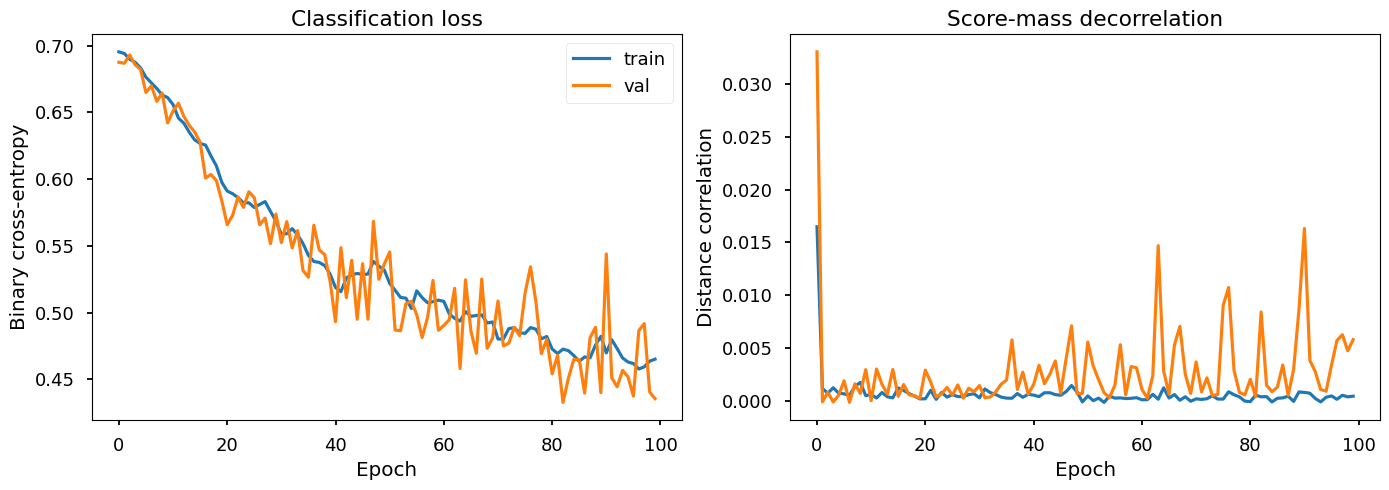

In [ ]:

# Visual summary of training history (losses, AUC, decorrelation, throughput).
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# Panel 0: weighted binary cross-entropy on train vs validation sets.
axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary cross-entropy")
axes[0].set_title("Loss history")
axes[0].legend()

# Panel 1: AUC progression across epochs (higher is better signal/background separation).
axes[1].plot(history_df["epoch"], history_df["val_auc"], marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")
axes[1].set_title("Validation ROC AUC")
axes[1].grid(True)

# Panel 2: distance correlation term monitoring the DisCo penalty strength.
if "train_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["train_dCorr_s_m"], label="train")
if "val_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["val_dCorr_s_m"], label="val")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Distance correlation")
axes[2].set_title("Decorrelating score vs jet mass")
axes[2].legend()

# Panel 3: runtime throughput useful for planning segmented jobs under time limits.
axes[3].plot(history_df["epoch"], history_df["train_examples_per_second"], label="train", marker="o")
axes[3].plot(history_df["epoch"], history_df["val_examples_per_second"], label="val", marker="s")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Examples per second")
axes[3].set_title("Throughput diagnostics")
axes[3].legend()

plt.tight_layout()
plt.show()




## 6. Evaluation (`evaluation.py` lines 1-70)

We reproduce the single-score diagnostics: ROC curves, background mass sculpting, and the Jensen-Shannon divergence versus background rejection figure of merit used in the paper.


Test AUC = 0.881
Background distance-correlation(score, mass) = 0.0062
JSDvsR 10 0.099992
JSDvsR 30 0.30001602
JSDvsR 50 0.5


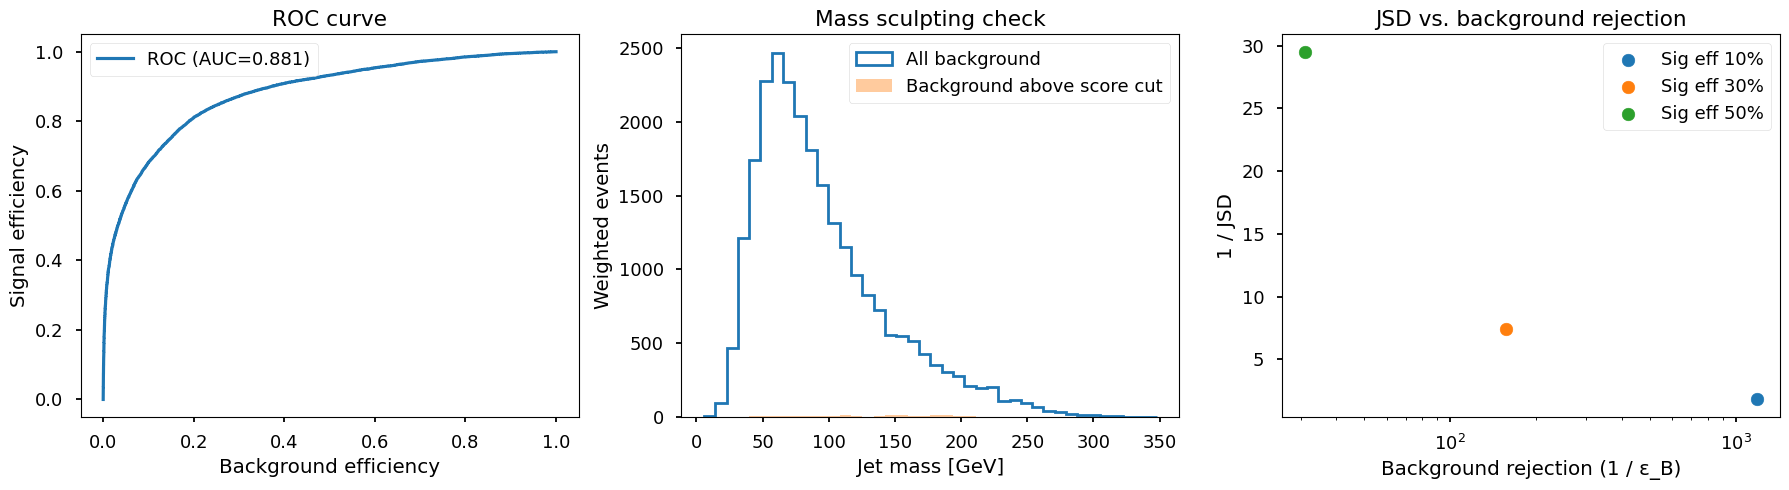

In [ ]:

# Final evaluation on the held-out test set following the evaluation guide.
from importlib import reload
import evaluation
reload(evaluation)
from evaluation import JSDvsR

# Run the evaluate() helper to obtain raw scores, labels, weights, masses.
s_test, y_test, w_test, m_test, test_metrics = evaluate(model, test_loader)

# Compute the suite of diagnostics requested: classification metrics, ROC, ABCD closure,
# Jensen–Shannon vs rejection, and distance correlation on pure background.
classification_test = compute_epoch_classification_metrics(s_test, y_test, w_test)
roc_test = compute_roc_diagnostics(s_test, y_test, w_test)
abcd_test = compute_abcd_statistics(s_test, m_test, y_test, w_test)
jsd_test = compute_jsd_summary(s_test, m_test, y_test, w_test)

background = y_test < 0.5
if background.any():
    d_test = distance_corr_safe(
        torch.as_tensor(s_test[background]),
        torch.as_tensor(m_test[background]),
        torch.ones_like(torch.as_tensor(m_test[background])),
    ).item()
else:
    d_test = float("nan")

print("Test-set diagnostics:")
print(f"  AUC = {roc_test['auc']:.3f}")
print(f"  Accuracy = {classification_test['accuracy']:.3f}")
print(f"  Precision = {classification_test['precision']:.3f}")
print(f"  Recall = {classification_test['recall']:.3f}")
print(f"  F1-score = {classification_test['f1']:.3f}")
print(f"  Background distance-correlation(score, mass) = {d_test:.4f}")

# Visualise ROC, confusion matrix, mass sculpting, and ABCD closure vs rejection.
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()
axes[0].plot(roc_test["fpr"], roc_test["tpr"], label=f"ROC (AUC={roc_test['auc']:.3f})")
axes[0].set_xlabel("Background efficiency ε_B")
axes[0].set_ylabel("Signal efficiency ε_S")
axes[0].set_title("Receiver Operating Characteristic")
axes[0].legend(loc="lower right")
axes[0].grid(True)
cm = classification_test["confusion_matrix"]
im = axes[1].imshow(cm, cmap="viridis")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(["Predicted background", "Predicted signal"])
axes[1].set_yticklabels(["True background", "True signal"])
axes[1].set_title("Weighted confusion matrix")
for (i, j), value in np.ndenumerate(cm):
    axes[1].text(j, i, f"{value:.0f}", ha="center", va="center", color="white" if value > cm.max() / 2 else "black")
fig.colorbar(im, ax=axes[1])
nbins = ABCD_HISTOGRAM_BINS
mass_range = (m_test.min(), m_test.max())
axes[2].hist(
    m_test[background], bins=nbins, range=mass_range, weights=w_test[background],
    histtype="step", label="All background", linewidth=2
)
cut = weighted_quantile(s_test[y_test > 0.5], 1 - 0.3, w_test[y_test > 0.5])
sel = background & (s_test > cut)
axes[2].hist(
    m_test[sel], bins=nbins, range=mass_range, weights=w_test[sel],
    histtype="stepfilled", alpha=0.4, label="Background above 30% signal-eff cut"
)
axes[2].set_xlabel("Jet mass [GeV]")
axes[2].set_ylabel("Weighted events")
axes[2].set_title("Mass sculpting diagnostic")
axes[2].legend()
rejections = [item["background_rejection"] for item in jsd_test]
closures = [item["closure_ratio"] for item in abcd_test["per_efficiency"]]
labels_eff = [int(item["target_signal_efficiency"] * 100) for item in abcd_test["per_efficiency"]]
axes[3].scatter(rejections, closures, c=labels_eff, cmap="plasma", s=120)
for rej, clo, eff in zip(rejections, closures, labels_eff):
    axes[3].annotate(f"{eff}%", (rej, clo))
axes[3].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
axes[3].set_xlabel("Background rejection 1/ε_B")
axes[3].set_ylabel("Closure ratio N_pred/N_true")
axes[3].set_title("ABCD closure vs. rejection")
axes[3].set_xscale("log")
axes[3].legend()
plt.tight_layout()
plt.show()

# Tabulate ABCD and JSD results for the notebook summary.
abcd_rows = []
for abcd_entry, jsd_entry in zip(abcd_test["per_efficiency"], jsd_test):
    eff = int(abcd_entry["target_signal_efficiency"] * 100)
    abcd_rows.append({
        "signal_efficiency_percent": eff,
        "score_cut": abcd_entry["score_cut"],
        "background_prediction": abcd_entry["predicted_bg"],
        "closure_ratio": abcd_entry["closure_ratio"],
        "closure_error_percent": abcd_entry["closure_error_pct"],
        "pull": abcd_entry["pull"],
        "transfer_factor_B_over_D": abcd_entry["transfer_factor_B_over_D"],
        "transfer_factor_C_over_D": abcd_entry["transfer_factor_C_over_D"],
        "sideband_ratio_B_over_C": abcd_entry["sideband_ratio_B_over_C"],
        "sideband_stability": abcd_entry["sideband_stability"],
        "signal_in_A": abcd_entry["signal_in_A"],
        "observed_total_in_A": abcd_entry["observed_total_in_A"],
        "asimov_significance": abcd_entry["asimov_significance"],
        "background_rejection": jsd_entry["background_rejection"],
        "inverse_jsd": jsd_entry["inverse_jsd"],
    })
abcd_df = pd.DataFrame(abcd_rows)
abcd_df

aggregated_df = pd.json_normalize(abcd_test["aggregated"], sep="_")
aggregated_df.T



## 7. Persist artefacts

Save inference scores and the trained model weights for downstream ABCDisCo or `pyhf` studies.


In [ ]:

# Persist raw test-set arrays and summary statistics for downstream analyses.
results_df = pd.DataFrame({
    "score": s_test,
    "label": y_test,
    "weight": w_test,
    "mass": m_test,
})
results_df.head()

summary_payload = {
    "classification": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v) if np.isscalar(v) else v) for k, v in classification_test.items() if k != "confusion_matrix"},
    "confusion_matrix": classification_test["confusion_matrix"].tolist(),
    "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v)) for k, v in roc_test.items()},
    "abcd": abcd_test,
    "jsd": jsd_test,
    "distance_correlation": d_test,
}
summary_path = CHECKPOINT_DIR / "test_evaluation.json"
with open(summary_path, "w") as handle:
    json.dump(summary_payload, handle, indent=2)
print(f"Saved detailed test summary to {summary_path}")


ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.


## 8. Extending to Double-DisCo & QML studies

- **Recovering the paper-level numbers**: set `FULL_DATASET = True`, increase `EPOCHS` to 200, and sweep `LAMBDA_MASS` in the range 50-400 as in the reference scans.
- **Quantum experiments**: switch `BACKEND = "qml"`, tune `N_QUBITS`/`QML_LAYERS`, and initialise the PennyLane device with `qml.seed(SEED)` for reproducibility.
- **Transition to Double-DisCo**: after validating this notebook, open `ABCDisCo_tutorial.ipynb` for the two-network variant and reuse the saved preprocessing steps to initialise the dual heads.
